In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
# vgg模型下載
vgg = VGG16(include_top = False,input_shape=(224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
# 讀取要訓練的圖像位置
import glob
import pandas as pd
# 先不讀圖片，要用在讀
df = pd.DataFrame(columns=['path',"target"])
for p in glob.glob(r'D:\desktop\AI_class\深度學習\train\cat.*.jpg'):
    s = pd.Series([p, 0], index =['path','target'])
    df = df.append(s,ignore_index=True)
for p in glob.glob(r'D:\desktop\AI_class\深度學習\train\dog.*.jpg'):
    s = pd.Series([p, 1], index =['path','target'])
    df = df.append(s,ignore_index=True)
df

,path,target
0,D:\desktop\AI_class\深度學習\train\cat.0.jpg,0
1,D:\desktop\AI_class\深度學習\train\cat.1.jpg,0
2,D:\desktop\AI_class\深度學習\train\cat.10.jpg,0
3,D:\desktop\AI_class\深度學習\train\cat.100.jpg,0
4,D:\desktop\AI_class\深度學習\train\cat.1000.jpg,0
...,...,...
24995,D:\desktop\AI_class\深度學習\train\dog.9995.jpg,1
24996,D:\desktop\AI_class\深度學習\train\dog.9996.jpg,1
24997,D:\desktop\AI_class\深度學習\train\dog.9997.jpg,1
24998,D:\desktop\AI_class\深度學習\train\dog.9998.jpg,1


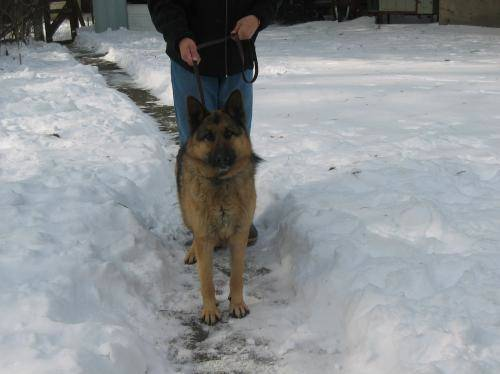

In [9]:
from tensorflow.keras.preprocessing.image import load_img
import random
c =random.randint(0,24999)
load_img(df['path'][c])

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,GlobalAveragePooling2D, Dropout

In [5]:
for i in vgg.layers:
    i.trainable = False
x = BatchNormalization()(vgg.output)  
x = GlobalAveragePooling2D()(x)
x = Dense(512, "relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, "softmax")(x)

cnn = Model(inputs=vgg.input,outputs=x)
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
)

In [7]:
from sklearn.model_selection import train_test_split
# 分切時pd->np
from tensorflow.keras.utils import to_categorical
import numpy as np

y_cat = to_categorical(df['target'])
x_train, x_test, y_train, y_test = train_test_split(np.array(df['path']),
                                                    np.array(y_cat),
                                                    test_size=0.1,
                                                     )

In [10]:
from tensorflow.keras.applications.vgg16 import preprocess_input

batch_size = 20
for i in range(5):
    idx = np.random.choice(range(0,x_train.shape[0]) ,batch_size)
    imglist=[]

    for fn in x_train[idx]:
        img = load_img(fn,target_size=(224,224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x,y)
    
    print("-------------Times",i,'------------')
    print("loss : ",result[0],",accuracy : ",result[1])

-------------Times 0 ------------
loss :  0.7064396142959595 ,accuracy :  0.550000011920929
-------------Times 1 ------------
loss :  0.5090889930725098 ,accuracy :  0.8500000238418579
-------------Times 2 ------------
loss :  0.5018518567085266 ,accuracy :  0.800000011920929
-------------Times 3 ------------
loss :  0.4909704625606537 ,accuracy :  0.75
-------------Times 4 ------------
loss :  0.3161372244358063 ,accuracy :  0.8999999761581421


In [11]:
batch_size =200

idx = np.random.choice(range(0,x_test.shape[0]) ,batch_size)
imglist=[]
oriimglist=[]
for fn in x_test[idx]:
    img = load_img(fn,target_size=(224,224))
    oriimglist.append(img)
    img = preprocess_input(np.array(img) )
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x,y)

7/7 [==============================] - 14s 820ms/step - loss: 0.3393 - accuracy: 0.8800


[0.3392575979232788, 0.8799999952316284]